In [1]:
!python3 --version

Python 3.7.15


In [2]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
# import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline

In [4]:
DATA_DIR = ''#Path.cwd().parent.resolve() / "data/final/public"
# DATA_DIR = '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/'#Path.cwd().parent.resolve() / "data/final/public"
# assert DATA_DIR.exists()

In [5]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [6]:
len(metadata.uid.unique())

23570

In [7]:
len(metadata.loc[:,['latitude','longitude' 	]].drop_duplicates())

12681

In [8]:
duplicated_rows=np.where(metadata.loc[:,['latitude','longitude']].duplicated()==True)[0]
duplicated_rows

array([   79,   106,   107, ..., 23565, 23566, 23569])

In [9]:
metadata.iloc[duplicated_rows[0],:]

uid                acdj
latitude        37.3906
longitude      -120.958
date         2015-04-14
split             train
Name: 79, dtype: object

In [10]:
metadata.loc[metadata['latitude']==metadata.latitude.iloc[duplicated_rows[0]],:].head()

,uid,latitude,longitude,date,split
22,aaqc,37.3906,-120.958,2013-07-09,train
79,acdj,37.3906,-120.958,2015-04-14,train
1701,bxeq,37.3906,-120.958,2019-09-10,train
2302,conk,37.3906,-120.958,2019-12-04,train
2409,crja,37.3906,-120.958,2021-07-13,train


In [11]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [12]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


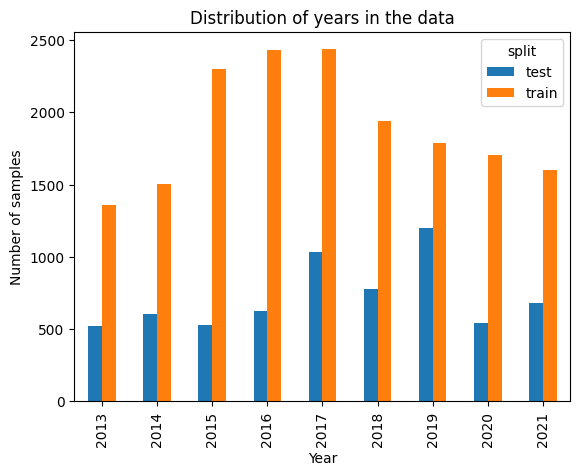

In [13]:
# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")
plt.show()

In [14]:
# what seasons are the data points from?

metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

In [15]:
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [16]:
train_labels.shape

(17060, 4)

In [17]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

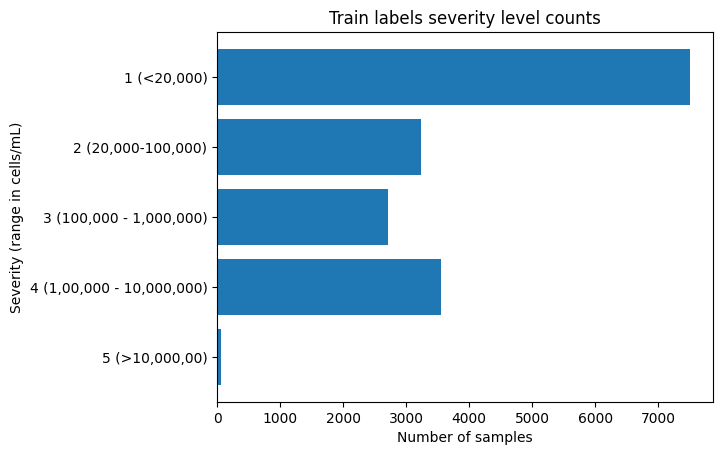

In [18]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [19]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [20]:
(train_labels.density == 0).sum()

91

In [21]:
metadata.shape,train_labels.shape

((23570, 6), (17060, 4))

In [22]:
#ADD train labels to metadata

metadata=metadata.merge(train_labels,on='uid',how='left')
metadata.loc[:,['severity','density']]=metadata.loc[:,['severity','density']].fillna(-1)

In [23]:
metadata

,uid,latitude,longitude,date,split,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,NaN,-1.0,-1.0
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,winter,NaN,-1.0,-1.0
23566,zzwo,39.792190,-99.971050,2017-06-19,train,summer,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,spring,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,fall,south,1.0,9682.0


In [24]:
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [25]:
submission_format.shape

(6510, 2)

In [26]:
metadata.shape

(23570, 9)

In [27]:
len(submission_format)+len(train_labels)-len(metadata)


0

In [28]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                         garm
latitude                41.98006
longitude             -110.65734
date         2021-09-27 00:00:00
split                      train
season                      fall
region                      west
severity                     5.0
density              12267752.74
Name: 5461, dtype: object

In [29]:
def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()
    stds = np.std(image_array, axis=(1, 2)).tolist()

    # c0 = int(image_array.shape[1]/2)
    # c1 = int(image_array.shape[1]/2)
    # averages_zoomin = image_array[:,c0-1:c0+1,c1-1:c1+1].mean(axis=(1, 2)).tolist()
    # medians_zoomin = np.median(image_array[:,c0-1:c0+1,c1-1:c1+1], axis=(1, 2)).tolist()

    return averages + medians + stds #+averages_zoomin + medians_zoomin

In [30]:
# take a random subset of the training data for the benchmark
# train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)
train_subset = metadata[metadata["split"] == "train"]

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [31]:
# np.abs(altDF.altitude-altDF.altitude.astype(int)).sum()

In [32]:
#to be used in group kfold split

metadata['latlong']=metadata['latitude'].round(2).astype(str)+'_'+metadata['longitude'].round(2).astype(str)
metadata['latlong1']=metadata['latitude'].round(1).astype(str)+'_'+metadata['longitude'].round(1).astype(str)
metadata['latlong0']=metadata['latitude'].round(0).astype(str)+'_'+metadata['longitude'].round(0).astype(str)
metadata['latlong10']=metadata['latitude'].round(1).astype(str)+'_'+metadata['longitude'].round(0).astype(str)
unique_points=np.unique(metadata.latlong)
unique_points1=np.unique(metadata.latlong1)
unique_points0=np.unique(metadata.latlong0)
unique_points10=np.unique(metadata.latlong10)
# metadata.head()

In [33]:
# metadata.shape,altDF.shape

In [34]:
#GET geomorhological features
DEM_DATA_DIR = "benchmark/dem/"#DATA_DIR.parents[1] / "benchmark"
DEM_DATA_DIR = "benchmark/dem2K/"#DATA_DIR.parents[1] / "benchmark"
geomorthology_files=os.listdir(DEM_DATA_DIR)
len(geomorthology_files),geomorthology_files[0]

(23556, 'oeuw_alt123.jpg')

In [35]:


# RESIZE_SIZE=128
DEM_RESIZE_SIZE=32
dem_featuresL=[]
rgbDEM=[]
for f in tqdm(geomorthology_files):
# for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    im = cv2.imread(DEM_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)

    dem_features = image_to_features(np.expand_dims(im,0))
    dem_featuresL.append(dem_features)
    if im.max()!=im.min():
        im=(im-im.min())/(im.max()-im.min())
    else:
        im*=0
    im=cv2.resize(im,(DEM_RESIZE_SIZE, DEM_RESIZE_SIZE))
    rgbDEM.append((im*255).astype('uint8'))
        
rgbDEM=np.stack(rgbDEM)    
dem_featuresL=np.stack(dem_featuresL)    


100%|██████████| 23556/23556 [02:47<00:00, 140.54it/s]


In [36]:
np.savez_compressed('dem2K', a=rgbDEM, b=dem_featuresL)

In [37]:
dem_featuresL.shape
geo_uids=[x.split('_')[0] for x in geomorthology_files]
geo_alts=[int(x.split('_')[1].split('.')[0][3:]) for x in geomorthology_files]
geo_uids[:5],geo_alts[:5]

(['oeuw', 'tjhp', 'crel', 'zqhi', 'estg'], [123, 19, 8, 85, -4])

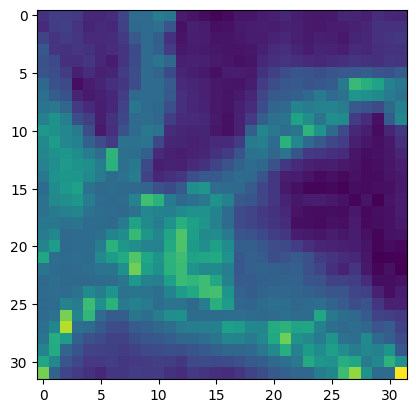

In [38]:
plt.imshow(rgbDEM[101])
plt.show()

In [39]:
rgbDEM.shape

(23556, 32, 32)

In [40]:
# altDF=pd.DataFrame(np.stack([[('_').join(x.split('_')[:2]),float(x.split('_')[-1][3:-4])] for x in geomorthology_files]),columns=['latlong','altitude'])
# altDF['altitude']=altDF['altitude'].astype(float)
altDF=pd.DataFrame(geo_uids,columns=['uid'])
altDF['altitude']=geo_alts
altDF['altitude']=altDF['altitude'].fillna(altDF['altitude'].median)

altDF['DEMmean']=dem_featuresL[:,0]
altDF['DEMmedian']=dem_featuresL[:,1]
altDF['DEMstd']=dem_featuresL[:,2]
altDF.head()


,uid,altitude,DEMmean,DEMmedian,DEMstd
0,oeuw,123,108.174279,104.5,47.364784
1,tjhp,19,107.601538,103.0,33.233621
2,crel,8,62.676179,40.0,64.743936
3,zqhi,85,109.822581,105.0,54.010357
4,estg,-4,62.576923,46.0,50.925415


In [41]:
cv2.imread(DEM_DATA_DIR+f, cv2.IMREAD_GRAYSCALE).shape

(26, 32)

In [42]:
# CLIMATE_DATA_DIR = "climate/"
# CLIMATE_DATA_DIR = "climate_again/"
# CLIMATE_DATA_DIR = "climate_1/"
# CLIMATE_DATA_DIR = "climate_14/"
# CLIMATE_DATA_DIR = "climate_14b/"
# CLIMATE_DATA_DIR = "climate_d14_b5000/"
# climate_files=os.listdir(CLIMATE_DATA_DIR)
# CLIM_RESIZE_SIZE=3
# clim_featuresL=[]
# rgbCLIM=[]
# climIds=[]
# for f in tqdm(climate_files):
#     try:
        
#     # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
#     #     im = cv2.imread(CLIMATE_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
#         im = np.load(CLIMATE_DATA_DIR+f)['a']
#         notnans = np.where(im[:,0,0]!=-999)[0]
#         if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)

#     #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
#             clim_features = image_to_features(im2)
#     #         clim_features = image_to_features(im)
#             clim_featuresL.append(clim_features)
#         #     if im.max()!=im.min():
#         #         im=(im-im.min())/(im.max()-im.min())
#         #     else:
#         #         im*=0
#             im=np.expand_dims(im[0,...,notnans[0]], -1)
#             im=cv2.resize(im.astype(np.float32),(CLIM_RESIZE_SIZE, CLIM_RESIZE_SIZE))
#         #     rgbCLIM.append((im*255).astype('uint8'))
#             rgbCLIM.append(im.astype(int))

#             climIds.append(f.split('.')[0])
#     except:
#         pass
        
# rgbCLIM=np.stack(rgbCLIM)    
# clim_featuresL=np.stack(clim_featuresL)    
# climIds=np.stack(climIds)

In [43]:
# clim_featuresL.shape,rgbCLIM.shape

In [44]:
# clim_featuresLw1=[]
# climIdsw1=[]
# for f in tqdm(climate_files):
#     try:
        
#     # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
#     #     im = cv2.imread(CLIMATE_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
#         im = np.load(CLIMATE_DATA_DIR+f)['a']
#         im=im[:7,...] #only first weak
#         notnans = np.where(im[:,0,0]!=-999)[0]
#         if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)

#     #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
#             clim_features = image_to_features(im2)
#     #         clim_features = image_to_features(im)
#             clim_featuresLw1.append(clim_features)


#             climIdsw1.append(f.split('.')[0])
#     except:
#         pass
    
# clim_featuresLw1=np.stack(clim_featuresLw1)    
# climIdsw1=np.stack(climIdsw1)    

In [45]:
# clim_featuresLw1.shape

In [46]:
CLIMATE_DATA_DIR = "climate_d14_b5000/"
CLIMATE_DATA_DIR = "climate_d28_b5000/"
climate_files=os.listdir(CLIMATE_DATA_DIR)
CLIM_RESIZE_SIZE=3
clim_featuresL=[]
# rgbCLIM=[]
climSeries=[]
climIds=[]
for f in tqdm(climate_files):
    try:
        
    # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    #     im = cv2.imread(CLIMATE_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
        im = np.load(CLIMATE_DATA_DIR+f)['a']
        notnans = np.where(im[:,0,0]!=-999)[0]
        if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)
    #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
            
            im2=np.mean(im,(1,2))
            im2[im2==-999]=np.nan
            # d14[d14==-999]=np.mean(d14[d14!=-999])
            im2=(pd.Series(im2).ffill()+pd.Series(im2).bfill())/2
            im2=pd.Series(im2).ffill()
            im2= pd.Series(im2).bfill().values
            im2 = np.reshape(im2,(1,1,len(im2)))

            clim_features = image_to_features(im2)
    #         clim_features = image_to_features(im)
            clim_featuresL.append(clim_features)
        #     if im.max()!=im.min():
        #         im=(im-im.min())/(im.max()-im.min())
        #     else:
        #         im*=0
            climSeries.append(im2[0,0,:])
#             im=np.expand_dims(im[0,...,notnans[0]], -1)
#             im=cv2.resize(im.astype(np.float32),(CLIM_RESIZE_SIZE, CLIM_RESIZE_SIZE))
#         #     rgbCLIM.append((im*255).astype('uint8'))
#             rgbCLIM.append(im.astype(int))

            climIds.append(f.split('.')[0])
    except:
        pass
        
climSeries=np.stack(climSeries)
# rgbCLIM=np.stack(rgbCLIM)    
clim_featuresL=np.stack(clim_featuresL)    
climIds=np.stack(climIds)

In [47]:

# climSeries.shape,clim_featuresL.shape

In [48]:
# plt.plot(climSeries[10],'.-')
# plt.show()

In [49]:
clim_featuresLw1=[]
climIdsw1=[]
for f in tqdm(climate_files):
    try:
        
    # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    #     im = cv2.imread(CLIMATE_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
        im = np.load(CLIMATE_DATA_DIR+f)['a']
        im=im[:7,...] #only first weak
        notnans = np.where(im[:,0,0]!=-999)[0]
        if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
            
            im2=np.mean(im,(1,2))
            im2[im2==-999]=np.nan
            # d14[d14==-999]=np.mean(d14[d14!=-999])
            im2=(pd.Series(im2).ffill()+pd.Series(im2).bfill())/2
            im2=pd.Series(im2).ffill()
            im2= pd.Series(im2).bfill().values
            im2 = np.reshape(im2,(1,1,len(im2)))
            
            clim_features = image_to_features(im2)
    #         clim_features = image_to_features(im)
            clim_featuresLw1.append(clim_features)


            climIdsw1.append(f.split('.')[0])
    except:
        pass
    
clim_featuresLw1=np.stack(clim_featuresLw1)    
climIdsw1=np.stack(climIdsw1)    

In [50]:
gc.collect()

7383

In [51]:
CLIMATE_R_DATA_DIR = "climate_rain_d28_b5000/"
climate_files=os.listdir(CLIMATE_R_DATA_DIR)
CLIM_RESIZE_SIZE=3
clim_featuresR=[]
# rgbCLIM=[]
climSeriesR=[]
climIdsR=[]
for f in tqdm(climate_files):
    try:
        
    # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    #     im = cv2.imread(CLIMATE_R_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
        im = np.load(CLIMATE_R_DATA_DIR+f)['a']
        notnans = np.where(im[:,0,0]!=-999)[0]
        if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)
    #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
            
            im2=np.mean(im,(1,2))
            im2[im2==-999]=np.nan
            # d14[d14==-999]=np.mean(d14[d14!=-999])
            im2=(pd.Series(im2).ffill()+pd.Series(im2).bfill())/2
            im2=pd.Series(im2).ffill()
            im2= pd.Series(im2).bfill().values
            im2 = np.reshape(im2,(1,1,len(im2)))

            clim_features = image_to_features(im2)
    #         clim_features = image_to_features(im)
            clim_featuresR.append(clim_features)
        #     if im.max()!=im.min():
        #         im=(im-im.min())/(im.max()-im.min())
        #     else:
        #         im*=0
            climSeriesR.append(im2[0,0,:])
#             im=np.expand_dims(im[0,...,notnans[0]], -1)
#             im=cv2.resize(im.astype(np.float32),(CLIM_RESIZE_SIZE, CLIM_RESIZE_SIZE))
#         #     rgbCLIM.append((im*255).astype('uint8'))
#             rgbCLIM.append(im.astype(int))

            climIdsR.append(f.split('.')[0])
    except:
        pass
        
climSeriesR=np.stack(climSeriesR)
# rgbCLIM=np.stack(rgbCLIM)    
clim_featuresR=np.stack(clim_featuresR)    
climIdsR=np.stack(climIdsR)

In [52]:
# plt.plot(climSeriesR[100],'.-')
# plt.show()

In [53]:
CLIMATE_G_DATA_DIR = "climate_gust_d28_b5000/"
climate_files=os.listdir(CLIMATE_G_DATA_DIR)
CLIM_RESIZE_SIZE=3
clim_featuresG=[]
# rgbCLIM=[]
climSeriesG=[]
climIdsG=[]
for f in tqdm(climate_files):
    try:
        
    # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    #     im = cv2.imread(CLIMATE_G_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
        im = np.load(CLIMATE_G_DATA_DIR+f)['a']
        notnans = np.where(im[:,0,0]!=-999)[0]
        if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)
    #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
            
            im2=np.mean(im,(1,2))
            im2[im2==-999]=np.nan
            # d14[d14==-999]=np.mean(d14[d14!=-999])
            im2=(pd.Series(im2).ffill()+pd.Series(im2).bfill())/2
            im2=pd.Series(im2).ffill()
            im2= pd.Series(im2).bfill().values
            im2 = np.reshape(im2,(1,1,len(im2)))

            clim_features = image_to_features(im2)
    #         clim_features = image_to_features(im)
            clim_featuresG.append(clim_features)
        #     if im.max()!=im.min():
        #         im=(im-im.min())/(im.max()-im.min())
        #     else:
        #         im*=0
            climSeriesG.append(im2[0,0,:])
#             im=np.expand_dims(im[0,...,notnans[0]], -1)
#             im=cv2.resize(im.astype(np.float32),(CLIM_RESIZE_SIZE, CLIM_RESIZE_SIZE))
#         #     rgbCLIM.append((im*255).astype('uint8'))
#             rgbCLIM.append(im.astype(int))

            climIdsG.append(f.split('.')[0])
    except:
        pass
        
climSeriesG=np.stack(climSeriesG)
# rgbCLIM=np.stack(rgbCLIM)    
clim_featuresG=np.stack(clim_featuresG)    
climIdsG=np.stack(climIdsG)

In [54]:
# plt.plot(climSeriesG[100],'.-')
# plt.show()

In [55]:
CLIMATE_S_DATA_DIR = "climate_snowc_d28_b15000/"
climate_files=os.listdir(CLIMATE_S_DATA_DIR)
CLIM_RESIZE_SIZE=9
clim_featuresS=[]
# rgbCLIM=[]
climSeriesS=[]
climIdsS=[]
for f in tqdm(climate_files):
    try:
        
    # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    #     im = cv2.imread(CLIMATE_G_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
        im = np.load(CLIMATE_S_DATA_DIR+f)['a']
        notnans = np.where(im[:,0,0]!=-999)[0]
        if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)
    #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
            
            im2=np.mean(im,(1,2))
            im2[im2==-999]=np.nan
            # d14[d14==-999]=np.mean(d14[d14!=-999])
            im2=(pd.Series(im2).ffill()+pd.Series(im2).bfill())/2
            im2=pd.Series(im2).ffill()
            im2= pd.Series(im2).bfill().values
            im2 = np.reshape(im2,(1,1,len(im2)))

            clim_features = image_to_features(im2)
    #         clim_features = image_to_features(im)
            clim_featuresS.append(clim_features)
        #     if im.max()!=im.min():
        #         im=(im-im.min())/(im.max()-im.min())
        #     else:
        #         im*=0
            climSeriesS.append(im2[0,0,:])
#             im=np.expand_dims(im[0,...,notnans[0]], -1)
#             im=cv2.resize(im.astype(np.float32),(CLIM_RESIZE_SIZE, CLIM_RESIZE_SIZE))
#         #     rgbCLIM.append((im*255).astype('uint8'))
#             rgbCLIM.append(im.astype(int))

            climIdsS.append(f.split('.')[0])
    except:
        pass
        
climSeriesS=np.stack(climSeriesS)
# rgbCLIM=np.stack(rgbCLIM)    
clim_featuresS=np.stack(clim_featuresS)    
climIdsS=np.stack(climIdsS)

In [56]:
CLIMATE_H_DATA_DIR = "climate_hgt_d28_b15000/"
climate_files=os.listdir(CLIMATE_H_DATA_DIR)
CLIM_RESIZE_SIZE=9
clim_featuresH=[]
# rgbCLIM=[]
climSeriesH=[]
climIdsH=[]
for f in tqdm(climate_files):
    try:
        
    # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
    #     im = cv2.imread(CLIMATE_G_DATA_DIR+f, cv2.IMREAD_GRAYSCALE)
        im = np.load(CLIMATE_H_DATA_DIR+f)['a']
        notnans = np.where(im[:,0,0]!=-999)[0]
        if len(notnans)!=0:
#             im=np.transpose(im,(1,2,0))
#             im=np.expand_dims(im,0)
    #         clim_features = image_to_features(np.expand_dims(im,0))
#             im2=im.copy()
#             im2[im2==-999]= im2[im2!=-999].mean()
#             im2=np.mean(im2,-1)
            
            im2=np.mean(im,(1,2))
            im2[im2==-999]=np.nan
            # d14[d14==-999]=np.mean(d14[d14!=-999])
            im2=(pd.Series(im2).ffill()+pd.Series(im2).bfill())/2
            im2=pd.Series(im2).ffill()
            im2= pd.Series(im2).bfill().values
            im2 = np.reshape(im2,(1,1,len(im2)))

            clim_features = image_to_features(im2)
    #         clim_features = image_to_features(im)
            clim_featuresH.append(clim_features)
        #     if im.max()!=im.min():
        #         im=(im-im.min())/(im.max()-im.min())
        #     else:
        #         im*=0
            climSeriesH.append(im2[0,0,:])
#             im=np.expand_dims(im[0,...,notnans[0]], -1)
#             im=cv2.resize(im.astype(np.float32),(CLIM_RESIZE_SIZE, CLIM_RESIZE_SIZE))
#         #     rgbCLIM.append((im*255).astype('uint8'))
#             rgbCLIM.append(im.astype(int))

            climIdsH.append(f.split('.')[0])
    except:
        pass
        
climSeriesH=np.stack(climSeriesH)
# rgbCLIM=np.stack(rgbCLIM)    
clim_featuresH=np.stack(clim_featuresH)    
climIdsH=np.stack(climIdsH)

In [57]:
np.savez_compressed(CLIMATE_DATA_DIR[:-1], a=climSeries, b=clim_featuresL, c=climIds)
np.savez_compressed(CLIMATE_DATA_DIR[:-1]+'w1',  b=clim_featuresLw1, c=climIdsw1)
np.savez_compressed(CLIMATE_R_DATA_DIR[:-1], a=climSeriesR, b=clim_featuresR, c=climIdsR)
np.savez_compressed(CLIMATE_G_DATA_DIR[:-1], a=climSeriesG, b=clim_featuresG, c=climIdsG)
np.savez_compressed(CLIMATE_S_DATA_DIR[:-1], a=climSeriesS, b=clim_featuresS, c=climIdsS)
np.savez_compressed(CLIMATE_H_DATA_DIR[:-1], a=climSeriesH, b=clim_featuresH, c=climIdsH)

temp=np.load('climate_d28_b5000.npz')
climSeries=temp['a']
clim_featuresL=temp['b']
climIds=temp['c']

temp=np.load('climate_d28_b5000w1.npz')
clim_featuresLw1=temp['b']
climIdsw1=temp['c']

temp=np.load('climate_rain_d28_b5000.npz')
climSeriesR=temp['a']
clim_featuresR=temp['b']
climIdsR=temp['c']

temp=np.load('climate_gust_d28_b5000.npz')
climSeriesG=temp['a']
clim_featuresG=temp['b']
climIdsG=temp['c']

temp=np.load('climate_snowc_d28_b15000.npz')
climSeriesS=temp['a']
clim_featuresS=temp['b']
climIdsS=temp['c']

temp=np.load('climate_hgt_d28_b15000.npz')
climSeriesH=temp['a']
clim_featuresH=temp['b']
climIdsH=temp['c']

In [58]:
climSeries.shape, climSeriesR.shape, climSeriesG.shape, climSeriesS.shape, climSeriesH.shape,

((20502, 28), (20502, 28), (20502, 28), (20547, 28), (20547, 28))

In [59]:
# climIdsSeries=np.concatenate((np.expand_dims(climIds,1),climSeries),1)
# climIdsSeriesR=np.concatenate((np.expand_dims(climIdsR,1),climSeriesR),1)
# climIdsSeriesG=np.concatenate((np.expand_dims(climIdsG,1),climSeriesG),1)
# climIdsSeriesS=np.concatenate((np.expand_dims(climIdsS,1),climSeriesS),1)
# climIdsSeriesH=np.concatenate((np.expand_dims(climIdsH,1),climSeriesH),1)

In [60]:
climIdsSeries=pd.DataFrame(np.concatenate((np.expand_dims(climIds,1),climSeries),1), columns=['uid']+['Temp'+str(i) for i in range(28)])

climIdsSeriesR=pd.DataFrame(np.concatenate((np.expand_dims(climIdsR,1),climSeriesR),1), columns=['uid']+['Rain'+str(i) for i in range(28)])

climIdsSeriesG=pd.DataFrame(np.concatenate((np.expand_dims(climIdsG,1),climSeriesG),1), columns=['uid']+['Gust'+str(i) for i in range(28)])

climIdsSeriesS=pd.DataFrame(np.concatenate((np.expand_dims(climIdsS,1),climSeriesS),1), columns=['uid']+['Snowc'+str(i) for i in range(28)])

climIdsSeriesH=pd.DataFrame(np.concatenate((np.expand_dims(climIdsH,1),climSeriesH),1), columns=['uid']+['HGT'+str(i) for i in range(28)])



In [61]:
# rma,rmi = rgbCLIM.max(),rgbCLIM.min()
# rma,rmi 

In [62]:
# rgbCLIM=(((rgbCLIM.astype(float)-rmi)/(rma-rmi))*255).astype('uint8')

In [63]:
# # rgbCLIM[0][:,:,[0,15,29]].astype('uint8').max()
# rgbCLIM.max(),rgbCLIM.min()

In [64]:
# # plt.imshow(rgbCLIM[20][:,:,0].astype('uint8'))
# plt.imshow(rgbCLIM[21].astype('uint8'))
# plt.show()

In [65]:
# rgbCLIM.shape,rgbCLIM[1].shape,np.transpose(np.load(CLIMATE_DATA_DIR+f)['a'],(1,2,0)).shape

In [66]:
climIds.shape,clim_featuresL.shape


((20502,), (20502, 3))

In [67]:
# clim_featuresL=np.squeeze(clim_featuresL)

In [68]:
clim_featuresDF=pd.concat([pd.DataFrame(clim_featuresL,columns=['climate_mean','climate_median','climate_std']),
                           pd.DataFrame(climIds,columns=['uid'])],1)
clim_featuresDF.head()

/var/venv/cuda112py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,climate_mean,climate_median,climate_std,uid
0,15.510000,14.72,2.891339,waln
1,19.679286,19.53,3.257052,wlwd
2,23.263571,23.54,2.815118,zxdf
3,11.067143,11.58,2.001658,rzcf
4,27.039286,27.98,3.080568,djsa


In [69]:
clim_featuresW1DF=pd.concat([pd.DataFrame(clim_featuresLw1,columns=['climate_mean_fw','climate_median_fw','climate_std_fw']),
                           pd.DataFrame(climIdsw1,columns=['uid'])],1)
clim_featuresW1DF.head()

/var/venv/cuda112py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,climate_mean_fw,climate_median_fw,climate_std_fw,uid
0,15.577143,14.40,3.785377,waln
1,18.914286,18.52,3.163031,wlwd
2,20.622857,20.52,2.451622,zxdf
3,11.360000,11.72,2.610134,rzcf
4,26.665714,26.48,1.777662,djsa


In [70]:
clim_featuresRDF=pd.concat([pd.DataFrame(clim_featuresR,columns=['rain_mean','rain_median','rain_std']),
                           pd.DataFrame(climIdsR,columns=['uid'])],1)
clim_featuresRDF.head()

/var/venv/cuda112py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,rain_mean,rain_median,rain_std,uid
0,0.181429,0.0,0.381947,waln
1,0.212143,0.0,0.378166,wlwd
2,0.092857,0.0,0.267059,zxdf
3,0.060000,0.0,0.180317,rzcf
4,0.100714,0.0,0.268088,djsa


In [71]:
clim_featuresRDF[['rain_median']].value_counts()

rain_median
0.000000       19695
1.000000         134
0.040000          91
0.020000          56
0.060000          40
               ...  
0.266667           1
0.490000           1
0.220000           1
0.140000           1
0.441667           1
Length: 107, dtype: int64

In [72]:
clim_featuresGDF=pd.concat([pd.DataFrame(clim_featuresG,columns=['gust_mean','gust_median','gust_std']),
                           pd.DataFrame(climIdsG,columns=['uid'])],1)
clim_featuresGDF.head()

/var/venv/cuda112py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,gust_mean,gust_median,gust_std,uid
0,6.577143,6.62,2.962208,waln
1,5.080714,5.42,2.294039,wlwd
2,3.024286,2.26,2.655266,zxdf
3,1.992857,1.90,1.157734,rzcf
4,4.527857,4.50,2.498653,djsa


In [73]:
clim_featuresSDF=pd.concat([pd.DataFrame(clim_featuresS,columns=['snowc_mean','snowc_median','snowc_std']),
                           pd.DataFrame(climIdsS,columns=['uid'])],1)
clim_featuresSDF.head()
clim_featuresHDF=pd.concat([pd.DataFrame(clim_featuresH,columns=['hgt_mean','hgt_median','hgt_std']),
                           pd.DataFrame(climIdsH,columns=['uid'])],1)
clim_featuresHDF.head()

/var/venv/cuda112py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  
/var/venv/cuda112py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """


,hgt_mean,hgt_median,hgt_std,uid
0,120.442308,120.442308,0.000000e+00,waln
1,109.023669,109.023669,2.842171e-14,wlwd
2,309.899408,309.899408,0.000000e+00,zxdf
3,484.071429,484.071429,1.705303e-13,rzcf
4,161.089744,161.089744,2.842171e-14,djsa


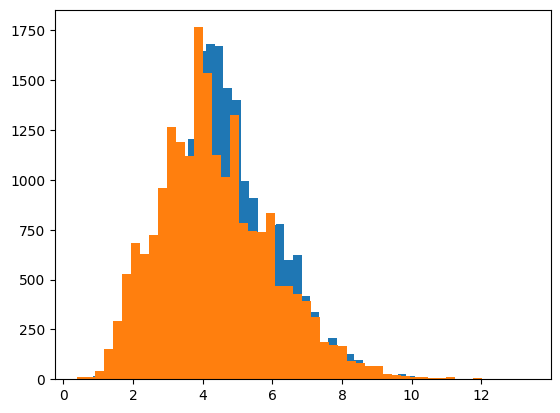

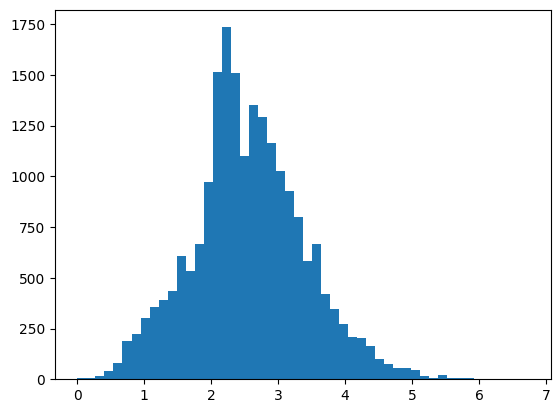

In [74]:
plt.hist(clim_featuresGDF.gust_mean,50)
plt.hist(clim_featuresGDF.gust_median,50)
plt.show()
plt.hist(clim_featuresGDF.gust_std,50)
plt.show()

In [75]:
# plt.imshow(rgbCLIM[0])
# plt.show()
# # plt.imshow( np.load(CLIMATE_DATA_DIR+f)['a'])
# # plt.show()

In [76]:
# clim_featuresL.shape,rgbCLIM.shape,im.shape, np.load(CLIMATE_DATA_DIR+f)['a'].shape,f,f.split('.')[0]
# clim_featuresL

In [77]:
metadata=metadata.merge(altDF,how='left').fillna(-1)
metadata.head()

,uid,latitude,longitude,date,split,season,region,severity,density,latlong,latlong1,latlong0,latlong10,altitude,DEMmean,DEMmedian,DEMstd
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,midwest,1.0,585.0,39.08_-86.43,39.1_-86.4,39.0_-86.0,39.1_-86.0,169.0,61.069930,22.5,68.402346
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,-1,-1.0,-1.0,36.56_-121.51,36.6_-121.5,37.0_-122.0,36.6_-122.0,30.0,62.063702,40.0,53.451200
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,south,1.0,290.0,35.88_-78.88,35.9_-78.9,36.0_-79.0,35.9_-79.0,94.0,130.127404,133.0,44.633880
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,south,1.0,1614.0,35.49_-79.06,35.5_-79.1,35.0_-79.0,35.5_-79.0,129.0,147.151442,152.0,50.721441
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,midwest,3.0,111825.0,38.05_-99.83,38.0_-99.8,38.0_-100.0,38.0_-100.0,702.0,132.240093,131.5,52.735658


In [78]:
dem_featuresL.shape,im.shape
# (im[...,0]-im[...,1]).sum()
# cv2.imread(DEM_DATA_DIR+f, cv2.IMREAD_GRAYSCALE).shape
dem_featuresL

array([[108.17427885, 104.5       ,  47.36478388],
       [107.60153846, 103.        ,  33.23362057],
       [ 62.67617866,  40.        ,  64.74393619],
       ...,
       [ 82.21153846,  78.        ,  33.90528325],
       [110.68629808, 116.        ,  56.38459457],
       [107.12379808,  96.        ,  55.43781436]])

In [79]:
gc.collect()

14905

In [80]:
# !pip3 install rasterio

    https://epic.awi.de/id/eprint/49883/1/remotesensing-11-01730.pdf

Band Wavelength (μm) | Resolution (m) | Band Wavelength (μm) | Resolution (m)  

                    |        LANDSAT       |       SENTINEL-2  

    Coastal Aerosol | 1 | 0.45–0.451  | 30 | 1  | 0.430–0.450 | 60

    Blue            | 2 | 0.452–0.51  | 30 | 2  | 0.448–0.546 | 10

    Green           | 3 | 0.533–0.59  | 30 | 3  | 0.538–0.583 | 10

    Red             | 4 | 0.636–0.673 | 30 | 4  | 0.646–0.684 | 10

    NIR             | 5 | 0.851–0.879 | 30 | 8A | 0.848–0.881 | 20

    NIR2                                   | 8 | 0.763–0.908 | 10

    SWIR1           | 6 | 1.566–1.651 | 30 | 11 | 1.542–1.685 | 20

    SWIR2           | 7 | 2.107–2.294 | 30 | 12 | 2.081–2.323 | 20

    Cirrus          | 9 | 1.363–1.384 | 30 | 10 | 1.336–1.441 | 60


In [81]:
import rasterio
def read_band(path,band='B4'):
    im0=os.listdir(path)[0].split('.')[0]
    b=rasterio.open(path+im0+'.'+band+'.tif' ).read()[0,...]
#     percB = np.percentile(b,[0.1,99.99])
#     b = np.clip(b, percB[0], percB[1])
    B=(((b-b.min())/(b.max()-b.min()))*255).astype('uint8')
    return(B)

TIME_BUFFER_DAYS=20
AREA_BUFFER = 500
CLOUDS_LESS_THAN=30

BASE_DIRs = 'EEtemp/S_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'/'
BASE_DIRl = 'EEtemp/L_t'+str(TIME_BUFFER_DAYS)+'_a'+str(AREA_BUFFER)+'_c'+str(CLOUDS_LESS_THAN)+'/'

num=1
file = BASE_DIRs+os.listdir(BASE_DIRs)[num]+'/'
# file = BASE_DIRl+os.listdir(BASE_DIRl)[num]+'/'
B4=read_band(file,band='B4')
B3=read_band(file,band='B3')
B2=read_band(file,band='B2')
RGB=np.stack((B4,B3,B2),-1)
RGB.shape

(103, 103, 3)

In [82]:
num=1
file = BASE_DIRl+os.listdir(BASE_DIRl)[num]+'/'
im0=os.listdir(file)[0].split('.')[0]+'.B2.tif'
b=rasterio.open(file+im0 ).read()[0,...]
b.shape

(36, 35)

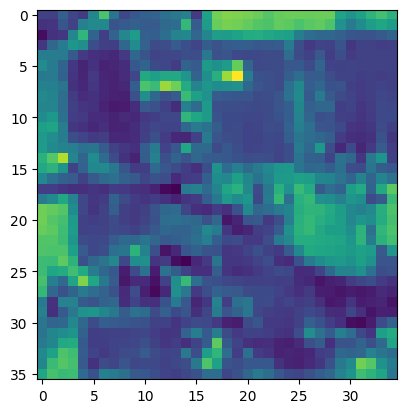

In [83]:
plt.imshow(b)
plt.show()
# np.unique(b),b.mean(),b[8:-8,8:-8].mean()

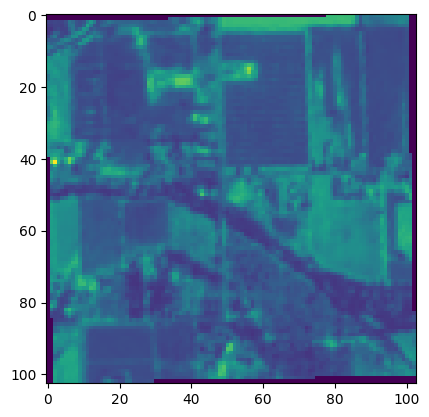

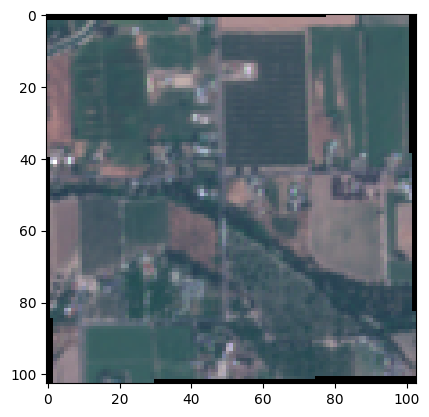

In [84]:
plt.imshow(B4)
plt.show()
plt.imshow(RGB)
plt.show()

In [95]:
# RGBr=cv2.resize(RGB, (300,300))
# plt.imshow(RGBr)
# plt.show()
# RGBr=cv2.resize(RGB, (300,300), cv2.INTER_CUBIC)
# plt.imshow(RGBr)
# plt.show()

In [85]:
RESIZE_SIZE=64
BASE_DIR=BASE_DIRs

rgbsS=[]
idsS=[]

# for uid in tqdm(os.listdir(BASE_DIR)[:200], total=200):
for uid in tqdm(os.listdir(BASE_DIR)):

    file = BASE_DIR+uid+'/'
    
    try:
        B1=read_band(file,band='B1')
        B1=cv2.resize(B1,(RESIZE_SIZE, RESIZE_SIZE))
        B2=read_band(file,band='B2')
        B2=cv2.resize(B2,(RESIZE_SIZE, RESIZE_SIZE))
        B3=read_band(file,band='B3')
        B3=cv2.resize(B3,(RESIZE_SIZE, RESIZE_SIZE))
        B4=read_band(file,band='B4')
        B4=cv2.resize(B4,(RESIZE_SIZE, RESIZE_SIZE))
#         B5=read_band(file,band='B8A')############################################
        B5=read_band(file,band='B8')
        B5=cv2.resize(B5,(RESIZE_SIZE, RESIZE_SIZE))
        B6=read_band(file,band='B11')
        B6=cv2.resize(B6,(RESIZE_SIZE, RESIZE_SIZE))
        B7=read_band(file,band='B12')
        B7=cv2.resize(B7,(RESIZE_SIZE, RESIZE_SIZE))
#         B8=read_band(file,band='B10')
#         B8=cv2.resize(B8,(RESIZE_SIZE, RESIZE_SIZE))
#         allBands=np.stack((B1,B2,B3,B4,B5,B6,B7,B8),-1)
        allBands=np.stack((B1,B2,B3,B4,B5,B6,B7),-1)
        
#         allBands=cv2.resize(allBands,(RESIZE_SIZE, RESIZE_SIZE))
        
        rgbsS.append(allBands)
        idsS.append(uid)
    except:
        pass

#        
            
rgbsS=np.stack(rgbsS)    
idsS=np.stack(idsS) 

In [86]:
# rgbsS.shape,rgbsS[0][:,:,[3,2,1]].shape,allBands.shape

In [87]:
# plt.imshow(rgbsS[1112][:,:,[3,2,1]])
# plt.show()

In [88]:
RESIZE_SIZE=64
BASE_DIR=BASE_DIRl

rgbsL=[]
idsL=[]

# for uid in tqdm(os.listdir(BASE_DIR)[:200], total=200):
for uid in tqdm(os.listdir(BASE_DIR)):

    file = BASE_DIR+uid+'/'
    
    try:
        B1=read_band(file,band='B1')
        B1=cv2.resize(B1,(RESIZE_SIZE, RESIZE_SIZE))
        B2=read_band(file,band='B2')
        B2=cv2.resize(B2,(RESIZE_SIZE, RESIZE_SIZE))
        B3=read_band(file,band='B3')
        B3=cv2.resize(B3,(RESIZE_SIZE, RESIZE_SIZE))
        B4=read_band(file,band='B4')
        B4=cv2.resize(B4,(RESIZE_SIZE, RESIZE_SIZE))
        B5=read_band(file,band='B5')
        B5=cv2.resize(B5,(RESIZE_SIZE, RESIZE_SIZE))
        B6=read_band(file,band='B6')
        B6=cv2.resize(B6,(RESIZE_SIZE, RESIZE_SIZE))
        B7=read_band(file,band='B7')
        B7=cv2.resize(B7,(RESIZE_SIZE, RESIZE_SIZE))
#         B8=read_band(file,band='B9')
#         B8=cv2.resize(B8,(RESIZE_SIZE, RESIZE_SIZE))
        
        allBands=np.stack((B1,B2,B3,B4,B5,B6,B7),-1)
        
#         allBands=cv2.resize(allBands,(RESIZE_SIZE, RESIZE_SIZE))
        
        rgbsL.append(allBands)
        idsL.append(uid)
    except:
        pass

#        
            
rgbsL=np.stack(rgbsL)    
idsL=np.stack(idsL) 

In [89]:
# RESIZE_SIZE=20
# RESIZE_SIZEq=int(RESIZE_SIZE/4)
# BASE_DIR=BASE_DIRl

# L1011fs=[]
# idsLf=[]

# # for uid in tqdm(os.listdir(BASE_DIR)[:200], total=200):
# for uid in tqdm(os.listdir(BASE_DIR)):

#     file = BASE_DIR+uid+'/'
    
#     try:
#         B10=read_band(file,band='B10')
#         B10=cv2.resize(B10,(RESIZE_SIZE, RESIZE_SIZE))
#         B11=read_band(file,band='B11')
#         B11=cv2.resize(B11,(RESIZE_SIZE, RESIZE_SIZE))
        
#         B10mean=np.mean(B10)
#         B10Cmean=np.mean(B10[RESIZE_SIZEq:-RESIZE_SIZEq,RESIZE_SIZEq:-RESIZE_SIZEq])
#         B11mean=np.mean(B11)
#         B11Cmean=np.mean(B11[RESIZE_SIZEq:-RESIZE_SIZEq,RESIZE_SIZEq:-RESIZE_SIZEq])
        
        
#         L1011fs.append([B10mean,B10Cmean,B11mean,B11Cmean])
#         idsLf.append(uid)
#     except:
#         pass

# #        
            
# L1011fs=np.stack(L1011fs)   
# idsLf=np.stack(idsLf)

In [96]:
gc.collect()


5952

In [97]:
np.savez_compressed('L_t20_a500_c30', a=idsL, b=rgbsL)
np.savez_compressed('S_t20_a500_c30', a=idsS, b=rgbsS)
# np.savez_compressed('S_t20_a500_c30_8', a=idsS, b=rgbsS) #band8 instead 8A
# np.savez_compressed('L_t20_a500_c30_B1011f', a=idsLf, b=L1011fs) #


In [98]:

# S_file='S_t20_a200_c30.npz'
# L_file='L_t20_a200_c30.npz'
S_file='S_t20_a500_c30.npz'
# S_file='S_t20_a500_c30_8.npz'
# L_file='L_t20_a500_c30.npz'
# temp=np.load(L_file)
# idsL=temp['a']
# rgbsL=temp['b']
temp=np.load(S_file)
idsS=temp['a']
rgbsS=temp['b']

In [99]:
# Lf_file='L_t20_a500_c30_B1011f.npz'
# temp=np.load(Lf_file)
# idsLf=temp['a']
# L1011fs=temp['b']

In [100]:
# idsLfDF=pd.DataFrame(np.concatenate((np.expand_dims(idsLf,-1), L1011fs),-1),columns=['uid', 'LB10mean','LB10Cmean','LB11mean','LB11Cmean'])
# idsLfDF[['LB10mean','LB10Cmean','LB11mean','LB11Cmean']]=idsLfDF[['LB10mean','LB10Cmean','LB11mean','LB11Cmean']].astype(float)
# idsLfDF.head()
